# Dirichlet case (q = 1)

The problem is formulated as follows: extremise $y(1)$ with ($A$ is the positive $L^1$ bound)

$$ -y''(t)+V(t)y(t) = 0,\quad \|V\|_1 \leq A, $$

$$ y(0)=0,\quad y'(0)=1. $$

Setting $x=(y,y',x_3)$ one equivalently extremises $x_1(1)$ s.t.

$$ x_1'(t) = x_2(t),\quad x_2'(t) = V(t)x_1(t),\quad x_3'(t)=|V(t)|, $$

$$ x(0)=(0,1,0),\quad x_3(1) \leq A. $$

To avoid singularities, the control $V$ is decomposed into the difference of its positive and negative parts; and to ensure existence in the $L^1$ class, an atom at time $\tau \in (0,1)$ is assumed and the problem recast on $[0,\tau]$ and $[\tau,1]$ with suitable junction conditions.

In [2]:
import Pkg
Pkg.activate()

using JuMP, Ipopt

# JuMP model, Ipopt solver
extdet = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 5))

# Parameters
A = 23.7                      # L^1 bound on the potential
t0 = 0.                       # initial time
tf = 1.                       # final time
N = 800                       # grid size
Δt = (tf-t0)/N                # step size
ε = -1.                       # sign of impulse

@variables(extdet, begin
    0 ≤ τ ≤ tf                # atom position
    0 ≤ Δ ≤ A                 # absolute value of atom amplitude
    x1[1:2, 1:N]              # x1 = y
    x2[1:2, 1:N]              # x2 = y'
    x3[1:2, 1:N]              # x3 for L^q constraint
    0 ≤ V1[1:2, 1:N]          # positive part of the potential (= control)
    0 ≤ V2[1:2, 1:N]          # negative part of the potential (= control)
end)

# Objective
@objective(extdet, Min, x1[2, N])

# Initial conditions
@constraints(extdet, begin
    x1[1, 1] == 0.
    x2[1, 1] == 1.
    x3[1, 1] == 0.
    x1[2, 1] == x1[1, N]
  # x2[2, 1]: nonlinear, see below
    x3[2, 1] == x3[1, N]
    x3[2, N] ≤ A-Δ
end)

@NLconstraint(extdet, x2[2, 1] == x2[1, N] + ε*Δ*x1[1, N]) # atom at tau

@constraint(extdet, 0.3 ≤ τ ≤ 0.7) #debug

# Dynamics, Crank-Nicolson scheme
for j in 1:N-1
    @NLconstraints(extdet, begin
        x1[1, j+1] == x1[1, j] + 0.5 * Δt *    τ  * (x2[1, j] + x2[1, j+1])
        x1[2, j+1] == x1[2, j] + 0.5 * Δt * (1-τ) * (x2[2, j] + x2[2, j+1])
        x2[1, j+1] == x2[1, j] + 0.5 * Δt *    τ  * ((V1[1, j]-V2[1, j])*x1[1, j] + (V1[1, j+1]-V2[1, j+1])*x1[1, j+1])
        x2[2, j+1] == x2[2, j] + 0.5 * Δt * (1-τ) * ((V1[2, j]-V2[2, j])*x1[2, j] + (V1[2, j+1]-V2[2, j+1])*x1[2, j+1])
        x3[1, j+1] == x3[1, j] + 0.5 * Δt *    τ  * ((V1[1, j]+V2[1, j]) + (V1[1, j+1]+V2[1, j+1]))
        x3[2, j+1] == x3[2, j] + 0.5 * Δt * (1-τ) * ((V1[2, j]+V2[2, j]) + (V1[2, j+1]+V2[2, j+1]))
    end)
end

  Activating project at `~/.julia/environments/v1.11`


ArgumentError: ArgumentError: Package JuMP not found in current path.
- Run `import Pkg; Pkg.add("JuMP")` to install the JuMP package.

In [92]:
# Solve for the control and state
println("Solving...")
status = optimize!(extdet)

# Display results
println("Solver status: ", status)
println("Cost: ", objective_value(extdet))
println("τ = ", value.(τ))
println("Δ = ", value.(Δ))

Solving...
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    33569
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:    78305

Total number of variables............................:     8002
                     variables with only lower bounds:     3200
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4800
Total number of inequality constraints...............:        3
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr

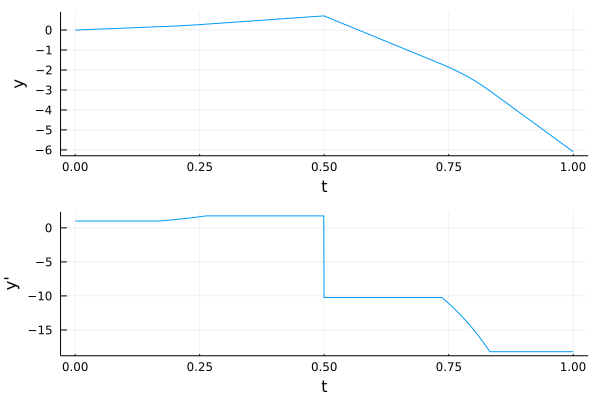

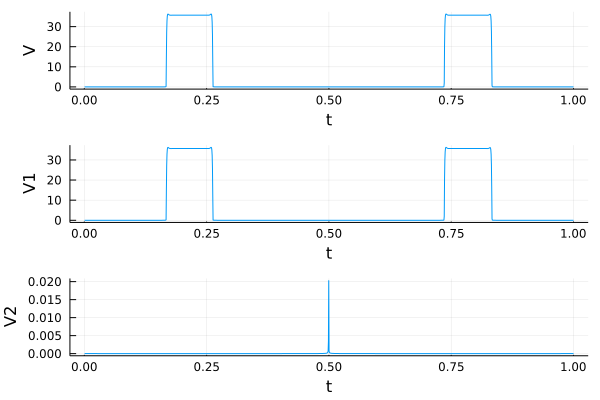

In [93]:
# Plots
using Plots

tt  = vcat(value.(τ)*Δt*(1:N), value.(τ) .+ value.(1-τ)*Δt*(1:N))
xx1 = vcat(value.(x1)[1, :], value.(x1)[2, :])
xx2 = vcat(value.(x2)[1, :], value.(x2)[2, :])
xx3 = vcat(value.(x3)[1, :], value.(x3)[2, :])
VV1 = vcat(value.(V1)[1, :], value.(V1)[2, :])
VV2 = vcat(value.(V2)[1, :], value.(V2)[2, :])
x1_plot = plot(tt, xx1, xlabel = "t", ylabel = "y",  label = "")
x2_plot = plot(tt, xx2, xlabel = "t", ylabel = "y'", label = "")
display(plot(x1_plot, x2_plot, layout = (2, 1)))
V_plot  = plot(tt, VV1-VV2, xlabel = "t", ylabel = "V",  label = "")
V1_plot = plot(tt, VV1,     xlabel = "t", ylabel = "V1", label = "")
V2_plot = plot(tt, VV2,     xlabel = "t", ylabel = "V2", label = "")
display(plot(V_plot, V1_plot, V2_plot, layout = (3, 1)))